In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

import seaborn as sns
import pandas as pd
%matplotlib inline
np.random.seed(111)
# tf.set_random_seed(111)

In [2]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


In [3]:
sphere_center = 300. #m 
sphere_radius = 100. #m
density_difference = 500. # kg/m^3: density diffrence to surrounding domain
x_domain=np.linspace(-1000,1000,101) #m

In [4]:
x_obs = np.linspace(-250, 250, 11)
grav_all = grav_analytical(x_domain, sphere_center, sphere_radius, density_difference)
grav_obs_array = grav_analytical(x_obs, sphere_center, sphere_radius, density_difference)
noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_noise = grav_obs_array + noise

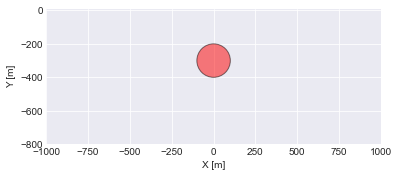

In [5]:
plt.style.use('seaborn-darkgrid')
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center), sphere_radius, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
plt.savefig('./Simple_grav_img/SG_noise_3_para/model.png')

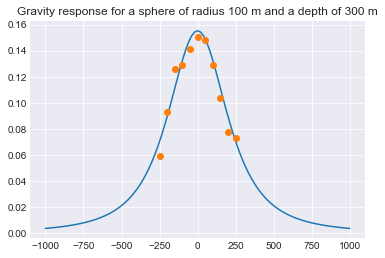

In [6]:
plt.plot(x_domain, grav_all)
plt.plot(x_obs, grav_obs_array_noise, 'o', label="data")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");
plt.savefig('./Simple_grav_img/SG_noise_3_para/gravity.png')

In [7]:
# create a log-likelihood function
def grav_analytical_tf(x):
    
    sphere_center = ed.Normal(
            loc = 280,scale = 10, name = "sphere_center")
    density_difference = ed.Normal(
            loc = 480,scale = 10, name = "density_difference")
    sphere_radius = ed.Normal(
            loc = 80,scale = 10, name = "sphere_radius")
    G=tf.constant(6.67e-11) # gravitational constant
    

#     gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 
    gravity = ed.Normal(
        loc =(((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 ),
        scale = 0.1,
        name = "gravity")
    
    return gravity


In [8]:
grav = grav_analytical_tf(x_obs)

In [9]:
with tf.Session() as sess:
    print(grav.eval())

[-0.07199948  0.04544251  0.08418786  0.10019824 -0.0440181   0.01317713
  0.1427086   0.02803242 -0.013476    0.1536382  -0.11795672]


In [10]:
sphere_center

300.0

In [11]:
log_joint = ed.make_log_joint_fn(grav_analytical_tf)

#function to compute the log posteior prob

# x_obs = tf.convert_to_tensor(x_obs,dtype = tf.float32)
# grav_obs_array_noise = tf.convert_to_tensor(grav_obs_array_noise, dtype = tf.float32)

def target_log_prob_fn(sphere_center,density_difference,sphere_radius):
    return log_joint(
        x = x_obs, 
        sphere_center =sphere_center,
        density_difference = density_difference,
        sphere_radius = sphere_radius,
        
        gravity = grav_obs_array_noise
        )

In [24]:
num_results = int(10e4) #number of hmc iterations
n_burnin = int(5e3)     #number of burn-in steps

step_size = 0.1
num_leapfrog_steps = 10



### HMC

In [25]:
# HMC transition kernel
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps)

# Define the chain states
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    
    #set initial state (drawn from prior)
    current_state=[
        tf.random_normal([], mean=280, stddev=10, dtype=tf.float32),
        tf.random_normal([], mean=480, stddev=10, dtype=tf.float32),
        tf.random_normal([], mean=80, stddev=10, dtype=tf.float32)

    ])


sphere_center,density_difference,sphere_radius = states

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [26]:
with tf.Session() as sess:
  [
      sphere_center_,
      density_difference_,
      sphere_radius_,
      is_accepted_,
  ] = sess.run([
      sphere_center,
      density_difference,
      sphere_radius,
      kernel_results.is_accepted,
  ])

# Samples after burn-in
sphere_center_samples = sphere_center_[n_burnin:]
density_difference_samples = density_difference_[n_burnin:]
sphere_radius_samples = sphere_radius_[n_burnin:]

accepted_samples = is_accepted_[n_burnin:]

In [27]:
print('Acceptance rate: %0.1f%%' % (100*np.mean(accepted_samples)))

Acceptance rate: 100.0%


In [28]:
def chain_plot(data, title='', ax=None):
  '''Plot both chain and posterior distribution'''
  if ax is None:
    ax = plt.gca()
  ax.plot(data)
  ax.title.set_text(title+" chain")
    
def post_plot(data, title='', ax=None, true=None, prc=95):
  '''Plot the posterior distribution given MCMC samples'''
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  tprc = (100-prc)/2
  
  ax.axvline(x=np.percentile(data, tprc), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-tprc), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)

    
def chain_post_plot(data, title='', ax=None, true=None):
  '''Plot a chain of MCMC samples'''
  chain_plot(data, title=title, ax=ax[0])
  post_plot(data, title=title, ax=ax[1], true=true)
  


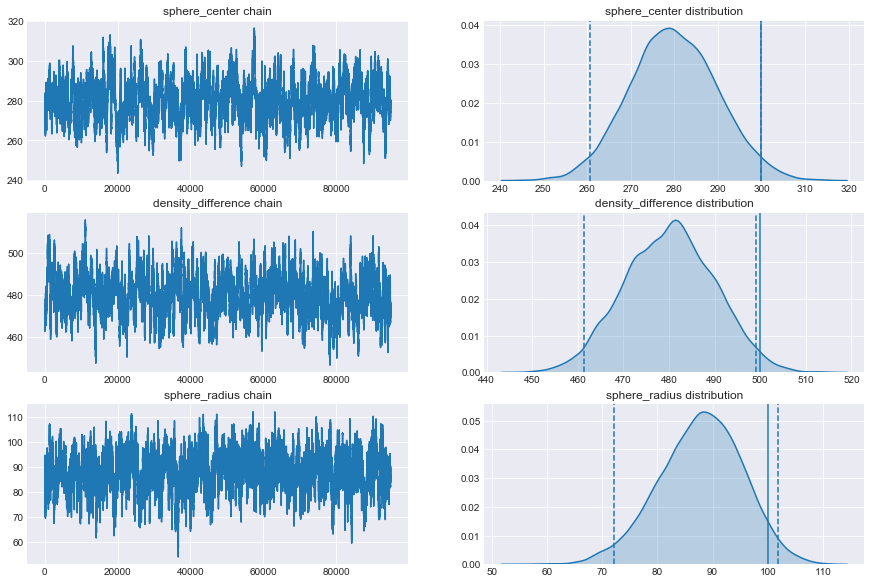

In [29]:
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False)
fig.set_size_inches(15, 10)

chain_post_plot(sphere_center_samples[:,],
                  title="sphere_center",
                  ax=axes[0], true=300)

chain_post_plot(density_difference_samples[:,],
                  title="density_difference",
                  ax=axes[1], true=500)

chain_post_plot(sphere_radius_samples[:,],
                  title="sphere_radius",
                  ax=axes[2], true=100)

# plt.savefig('./Simple_grav_img/HMC_0_noise.png')

#### RMH MCMC

In [21]:
num_results = int(10e4) #number of hmc iterations
n_burnin = int(5e3)     #number of burn-in steps

# n_burnin = 0     #number of burn-in steps

In [22]:
kernel=tfp.mcmc.RandomWalkMetropolis(
     target_log_prob_fn=target_log_prob_fn,
     seed=40)

# Define the chain states
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.random_normal([], mean=300, stddev=100, dtype=tf.float32),
        tf.random_normal([], mean=500, stddev=100, dtype=tf.float32),
        tf.random_normal([], mean=100, stddev=100, dtype=tf.float32)
#         tf.ones(sphere_center_size, name='init_sphere_center'),
    ])

sphere_center,density_difference,sphere_radius = states

with tf.Session() as sess:
  [
      sphere_center_,
      density_difference_,
      sphere_radius_,
      is_accepted_,
  ] = sess.run([
      sphere_center,
      density_difference,
      sphere_radius,
      kernel_results.is_accepted,
  ])

# Samples after burn-in
sphere_center_samples = sphere_center_[n_burnin:]
density_difference_samples = density_difference_[n_burnin:]
sphere_radius_samples = sphere_radius_[n_burnin:]

accepted_samples = is_accepted_[n_burnin:]

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


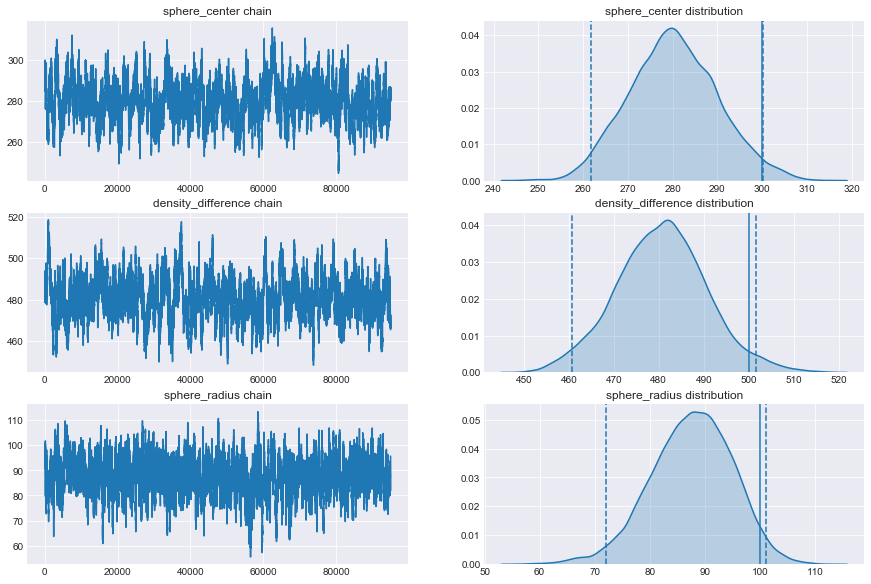

In [23]:
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False)
fig.set_size_inches(15, 10)

chain_post_plot(sphere_center_samples[:,],
                  title="sphere_center",
                  ax=axes[0], true=300)

chain_post_plot(density_difference_samples[:,],
                  title="density_difference",
                  ax=axes[1], true=500)

chain_post_plot(sphere_radius_samples[:,],
                  title="sphere_radius",
                  ax=axes[2], true=100)


# plt.savefig('./Simple_grav_img/RMH_MCMC_0_noise.png')

In [71]:
print('Acceptance rate: %0.1f%%' % (100*np.mean(accepted_samples)))

Acceptance rate: 93.7%
